In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("../LLM-Pruner/")

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import itertools
import pandas as pd

/home/daniel/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## True data setup

In [8]:
from download_data import fetch_data

In [10]:
# fetch_data()

In [2]:
from token_info import TokenInfo

/home/daniel/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
token_info = TokenInfo()

...Loading dataset...


FileNotFoundError: [Errno 2] No such file or directory: 'dataset_tokenized.pkl'

In [ ]:
top_tokens = token_info.top_n(10_000)

In [ ]:
top_tokens[0]

(13, '.', 3932482)

## Model and Tokenizer Setup

In [4]:
model_id = "microsoft/phi-1_5"
model_revision = "349cf8b5e81fd5f791d1740da5de1313a0419bbd" # latest as of feb 1st

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [11]:
vocab = tokenizer.get_vocab()
len(vocab)

50295

In [ ]:
# tokenizer.decode(token_info.get_prefixes(top_tokens[1000][0], 9, 10)[0])

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=model_revision,
    trust_remote_code=True,
    # be careful with this?
    torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
)

/home/daniel/miniconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [15]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,), e

## Dataset

In [16]:
from LLMPruner.datasets.example_samples import get_examples

ModuleNotFoundError: No module named 'LLMPruner'

In [ ]:
# examples = get_examples("bookcorpus", tokenizer, n_samples=10)
# pd.to_pickle(examples.cpu(), "./examples.pkl")
examples = pd.read_pickle("./examples.pkl")

In [ ]:
examples

tensor([[ 8182,   479,   672,  ...,   287, 10905,   306],
        [12284,   284,   766,  ...,  1257,   618,   673],
        [ 1058,   257,   380,  ...,   613,  6051,   837],
        ...,
        [  988,   290, 32627,  ...,   329,   262,  9546],
        [ 4868,   584,  3835,  ...,   279,  2518,    78],
        [ 7091,   714,  5368,  ...,   674, 15876,  1267]])

In [ ]:
examples = examples[:, :9]

In [ ]:
examples = examples.cuda()

In [ ]:
tokenizer.decode(examples[3])

', escaped 2/46, dunblane'

## Model importance computation

In [7]:
def get_mlps(model):
    layers = model.get_submodule("model").get_submodule("layers")
    return [layer.get_submodule("mlp") for layer in layers]

In [8]:
def custom_loss(logits, labels, model):
    # Returns crossentropy loss per token, w/o reduction
    
    # Shift so that tokens < n predict n
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    orig_shape = shift_labels.shape
    # Flatten the tokens
    loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
    shift_logits = shift_logits.view(-1, model.config.vocab_size)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels).view(orig_shape)
    return loss

In [ ]:
def compute_acc_grad_2(model, examples, mlps):
    # Computes the second term of the taylor expansion
    params = [list(mlp.parameters()) for mlp in mlps]
    params = itertools.chain.from_iterable(params) # flatten list
    res = model(examples, labels=examples)
    losses_tens = custom_loss(res.logits, examples, model)
    losses = [loss.mean() for loss in losses_tens]
    # import pdb; pdb.set_trace()
    for example_loss in losses:
        example_loss.backward(retain_graph=True)
        for param in params: # for all the weights
            num_examples = examples.shape[0]
            with torch.no_grad():
                grad = param.grad.detach()
                sq_grad = grad * grad / num_examples
                if hasattr(param, "acc_grad"):
                    param.acc_grad += sq_grad
                else:
                    param.acc_grad = sq_grad
        model.zero_grad()
        del example_loss
        torch.cuda.empty_cache()
    return losses_tens

In [ ]:
def compute_acc_grad(model, examples, mlps):
    # Computes the second term of the taylor expansion
    params = [list(mlp.parameters()) for mlp in mlps]
    params = itertools.chain.from_iterable(params) # flatten list
    
    for example in examples:
        example = example.unsqueeze(0)
        # import pdb; pdb.set_trace()
        loss = model(example, labels=example).loss
        # import pdb; pdb.set_trace()
        loss.backward()
        for param in params: # for all the weights
            num_examples = examples.shape[0]
            with torch.no_grad():
                grad = param.grad.detach()
                sq_grad = grad * grad / num_examples
                if hasattr(param, "acc_grad"):
                    param.acc_grad += sq_grad
                else:
                    param.acc_grad = sq_grad
        model.zero_grad()
        del loss
        torch.cuda.empty_cache()

In [ ]:
@torch.no_grad()
def compute_mlp_importance(mlps):
    # computes importance for hidden layers of MLP
    importances = []
    for mlp in mlps:
        fc1 = mlp.fc1
        fc2 = mlp.fc2
        # compute importance of inputs to hidden
        salience_w1 = fc1.weight * fc1.weight.grad
        salience_w2 = fc2.weight * fc2.weight.grad
        
        salience_w1 = salience_w1 - 0.5 * fc1.weight * fc1.weight.acc_grad * fc1.weight
        salience_w2 = salience_w2 - 0.5 * fc2.weight * fc2.weight.acc_grad * fc2.weight

        importance_w1_component =  salience_w1.abs().sum(dim=1)
        importance_w2_component =  salience_w2.abs().sum(dim=0)

        # analogous to group reduction?
        importance = importance_w1_component + importance_w2_component
        importances.append(importance.detach().cpu())
    return importances

In [ ]:
def compute_importances(model, examples, use_fast=False):
    # start = time()
    # returns importance for mlp examples
    mlps = get_mlps(model)
    mlps = [mlps[0], mlps[len(mlps)//2], mlps[-1]]
    # torch.cuda.synchronize()
    # start_2 = time()
    if use_fast:
        loss = compute_acc_grad_2(model, examples, mlps) # estimates hessian term of importance
    else:
        compute_acc_grad(model, examples, mlps) # estimates hessian term of importance
    torch.cuda.synchronize()
    # end_2 = time()
    # print(f"compute acc grad: {end_2 - start_2}")
    # import pdb; pdb.set_trace()
    if use_fast:
        # print("using fast")
        loss = loss.mean()
        loss.backward()
    else:
        loss = model(examples, labels=examples).loss
        loss.backward()
    importances = compute_mlp_importance(mlps)
    # torch.cuda.synchronize()
    # end = time()
    # print(f"compute ttl: {end - start}")
    return importances

In [ ]:
top_10k = token_info.top_n(10_000)

In [ ]:
top_10k[0][0]

13

In [ ]:
from tqdm import tqdm

In [ ]:
examples = token_info.get_prefixes(top_10k[0][0], 10, 10)

In [ ]:
tokenizer.decode(examples[0])

' a range of social, political, and literary activities.'

In [ ]:
importance_dict = {}

In [ ]:
for i, t_info in tqdm(enumerate(top_10k)):
    examples = token_info.get_prefixes(t_info[0], 10, 10)
    examples = torch.tensor(examples, device="cuda:0")
    importances = compute_importances(model, examples, use_fast=True)
    importance_dict[t_info] = importances
    if (i+1) % 100 == 0:
        pd.to_pickle(importance_dict, f"importances/importance_{i}.pkl")
        del importance_dict
        importance_dict = {}

5376it [1:20:10,  1.87s/it]

## Scratch code
feel free to ignore

In [9]:
mlps = get_mlps(model)

In [34]:
for mlp in mlps:
    m1 = mlp.fc1.weight
    m2 = mlp.fc2.weight
    print(m1.shape)

m1

torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])
torch.Size([8192, 2048])


Parameter containing:
tensor([[ 0.0114,  0.0332,  0.0078,  ..., -0.0405,  0.0556,  0.0304],
        [-0.0914,  0.0074,  0.0013,  ..., -0.0017, -0.0214,  0.0265],
        [ 0.0072,  0.0218, -0.0118,  ...,  0.0554, -0.0005,  0.0455],
        ...,
        [ 0.0269, -0.0411, -0.0190,  ...,  0.0100,  0.0140, -0.0545],
        [-0.0105, -0.0187, -0.0126,  ..., -0.0448, -0.0164,  0.0052],
        [-0.0128, -0.0186, -0.0025,  ...,  0.0057, -0.0007, -0.0217]],
       dtype=torch.float16, requires_grad=True)

In [10]:
import matplotlib.pyplot as plt

mlp = mlps[0]

m1 = mlp.fc1.weight.float()
m2 = mlp.fc2.weight.float()


U, S, Vt = torch.svd(m1)

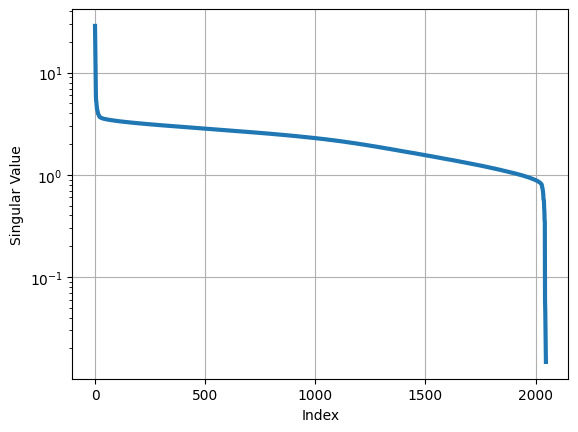

In [20]:
plt.plot(S.cpu().detach().numpy(), linestyle='-', linewidth=3)  # Convert S to CPU and numpy format if it's on GPU or in tensor format
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Singular Value')  # Label for the y-axis
# plt.title('Singular Values with Logarithmic Scale')  # Title of the plot
plt.grid(True)#, which="both", ls="--")  # Add a grid for better readability, applicable to both linear and log scales
plt.show()

In [ ]:
importances = _

In [ ]:
importances[0]

tensor([0.0172, 0.0293, 0.0263,  ..., 0.0334, 0.0138, 0.0241], device='cuda:0',
       dtype=torch.float16)

In [ ]:
mlps = get_mlps(model)

In [ ]:
examples.shape

torch.Size([10, 128])

In [ ]:
mlps = get_mlps(model)

In [ ]:
mlp = mlps[0]

In [ ]:
fc1 = mlp.get_submodule("fc1")
fc2 = mlp.get_submodule("fc2")

NameError: name 'mlp' is not defined

In [ ]:
fc1

Linear(in_features=2048, out_features=8192, bias=True)

In [ ]:
def compute_importance(mlp):
    pass

In [ ]:
modules = list(model.modules())

In [ ]:
x = model.get_submodule("model").get_submodule("layers")[0].get_submodule("mlp").get_submodule("fc1")

In [ ]:
list(x.parameters())[0].grad.shape

torch.Size([8192, 2048])